In [59]:
import random
import string
from collections import defaultdict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize   

In [2]:
data_path = 'aita_raw.csv'

In [3]:
df = pd.read_csv(data_path)
df = df.dropna(axis=0)
df['verdict'] = df['verdict'].str.lower()
df

,id,timestamp,title,body,edited,verdict,score,num_comments
0,1ytr72,1.393275e+09,[AITA] Construction worker here,I have been on a parking structure project for...,False,too close to call,63,9.0
1,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0
2,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0
3,1yu41e,1.393282e+09,[AITA] I Put My Empty Beer on a Bar Table,"Relevant Facts:\n\n1) It was a crowded bar, th...",False,nothing happened,45,7.0
4,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0
...,...,...,...,...,...,...,...,...
167755,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the a-hole,1373,304.0
167756,ex97ye,1.580577e+09,AITA for refusing to give my ticket to my brot...,[deleted],False,no a-holes here,4,16.0
167758,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the a-hole,4,15.0
167759,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the a-hole,280,140.0


In [4]:
print(df['verdict'].describe())
counts = df['verdict'].value_counts()
print(counts)

count             129953
unique               410
top       not the a-hole
freq               75393
Name: verdict, dtype: object
not the a-hole        75393
asshole               27449
no a-holes here       15129
everyone sucks         7417
not enough info        2713
                      ...  
no results                1
[meta]                    1
aunt with benefits        1
chump                     1
maybe not                 1
Name: verdict, Length: 410, dtype: int64


In [6]:
v = df['verdict']
df = df[v.replace(counts.gt(300))]

In [7]:
replace_dict = {
    'not the asshole': 'not the a-hole',
    'no a--holes here': 'no a-holes here'
}
df = df.replace({'verdict': replace_dict})

In [57]:
df['verdict'].value_counts()

not the a-hole     75766
asshole            27449
no a-holes here    15432
everyone sucks      7417
not enough info     2713
Name: verdict, dtype: int64

In [9]:
df['body'] = df['body'].str.lower()
df['body'] = df['body'].str.replace('[^\w\s]', '')

In [10]:
class LemmaTokenizer:
    ignore_tokens = string.punctuation
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if not any(i in t for i in self.ignore_tokens) and len(t) > 2]

In [11]:
tokenizer=LemmaTokenizer()
word_list = ['aita']

stop_words = set(ENGLISH_STOP_WORDS.union(word_list))
tokenized_stop = tokenizer(' '.join(stop_words))

In [13]:
vectorizer = TfidfVectorizer(max_features=1000, sublinear_tf=True, max_df=0.95, 
                             min_df=5, ngram_range=(1, 1), tokenizer=tokenizer, stop_words=tokenized_stop)
text_features = vectorizer.fit_transform(df['body'][:10000]).toarray()
feature_names = vectorizer.get_feature_names()

In [48]:
feature_rank = SelectKBest(chi2, k=500)
feature_rank.fit(text_features, df['verdict'][:10000])

SelectKBest(k=500, score_func=<function chi2 at 0x7ff6cb99c050>)

In [49]:
feat = []
for i, (score, feature) in enumerate(zip(feature_rank.scores_, feature_names)):
    feat.append((score, feature))
    
dfObj = pd.DataFrame(feat) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
263,7.496407,edit
480,6.914515,lane
312,5.701643,fight
219,5.109640,deleted
301,4.059153,family
...,...,...
871,0.036850,theyre
75,0.035807,based
529,0.032401,lying
433,0.029952,idk


In [50]:
X_trans = feature_rank.transform(text_features)

In [51]:
model = RandomForestClassifier(verbose=2)
model.fit(X_trans, df['verdict'][:10000])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=2, warm_start=False)

In [52]:
val = feature_rank.transform(vectorizer.transform(df['body'][10000:20000]))
val_true = df['verdict'][10000:20000]

In [53]:
def vis_pred(data, labels):
    predictions = model.predict(data)
    acc = accuracy_score(labels, predictions)
    print(acc)
    bal = balanced_accuracy_score(labels, predictions)
    print(bal)
    cm = confusion_matrix(labels, predictions, labels=list(df['verdict'].unique()))
    labels = list(df['verdict'].unique())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


0.6101
0.2022222046037681


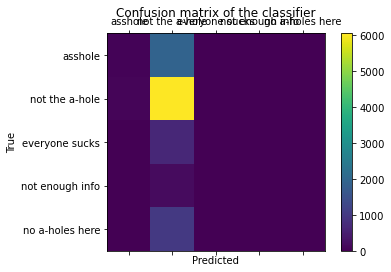

In [54]:
vis_pred(val, val_true)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.8965
0.721393335052148


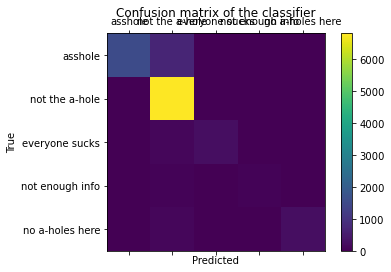

In [55]:
vis_pred(X_trans, df['verdict'][:10000])

In [56]:
random.shuffle(data)
train = data[:-20000]
valid = data[-20000:-10000]
test = data[-10000:]

In [63]:
vectorizer = TfidfVectorizer(max_features=1000, sublinear_tf=True, max_df=0.95, 
                             min_df=5, ngram_range=(1, 1))
text_features = vectorizer.fit_transform([t['body'] for t in train]).toarray()
feature_names = vectorizer.get_feature_names()

In [64]:
X = text_features
y = [t['verdict'] for t in train]

In [65]:
feature_rank = SelectKBest(chi2, k=100)
feature_rank.fit(X, y)
feat = []
for i, (score, feature) in enumerate(zip(feature_rank.scores_, feature_names)):
    feat.append((score, feature))
    
dfObj = pd.DataFrame(feat) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
258,67.295519,edit
556,47.386292,mom
566,43.136122,mother
991,34.236612,yelling
963,33.754569,wife
...,...,...
591,0.177423,normal
185,0.162011,context
983,0.098174,worth
849,0.066116,theres


In [66]:
model = LogisticRegression()
model.fit(X,y)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
cm = confusion_matrix([t['verdict'] for t in dataset], predictions, labels=list(df['verdict'].unique()))
labels = list(df['verdict'].unique())
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()